Training new model...
Starting predictions...


0it [00:00, ?it/s]


Epoch 1/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0910 - val_mean_squared_error: 0.0910
Epoch 2/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0910 - val_mean_squared_error: 0.0910
Epoch 3/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0910 - val_mean_squared_error: 0.0910
Epoch 4/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0910 - val_mean_squared_error: 0.0910
Epoch 5/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0883 - val_mean_squared_error: 0.0883
Epoch 6/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - val_loss: 0.0829 - val_mean_squared_error: 0.0829
Epoch 7/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0818 - mean_squared_error: 0.

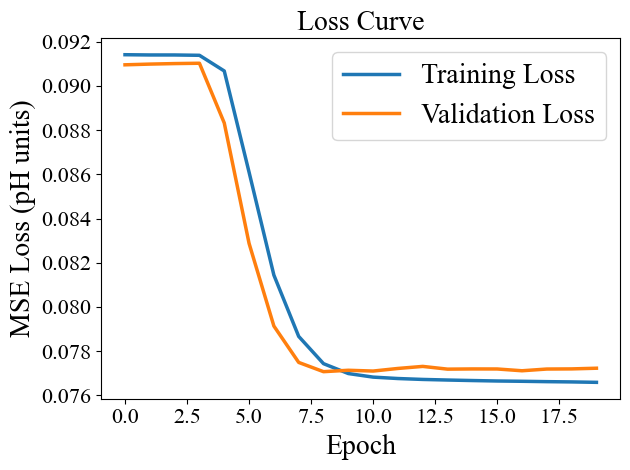

In [12]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from glob import glob
from matplotlib import pyplot as plt
from skimage import io
import os

def create_datasets_from_sample_ph(ph_path):
    '''
    :param ph_path: fold path containing standard pH sample images
    :return: an array with shape (62500*7, 4), including RGB values and corresponding pH label.
    '''
    ph_files = os.listdir(ph_path)
    datasets = np.zeros((62500*7, 4), dtype=np.float32)
    
    for i, ph in enumerate(ph_files):
        ph_v = float(ph.split('.')[0] + '.' + ph.split('.')[1])
        rgb = io.imread(os.path.join(ph_path, ph))
        rgb = rgb[400:650, 550:800]
        rgb = np.reshape(rgb, (-1, 3)) / 255
        ph_v = np.ones((rgb.shape[0], 1), dtype=np.float32) * ph_v
        data = np.concatenate((rgb, ph_v), axis=1)
        datasets[i*62500:(i+1)*62500] = data
    
    return datasets

def model_train_saving(datasets):
    '''
    Train a neural network model = model.pk00.keras
    '''
    def parse(x):
        return x[:3], x[-1]

    train_datasets, test_datasets = train_test_split(datasets, test_size=0.1, shuffle=True)
    train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets)
    train_datasets = train_datasets.map(parse).batch(batch_size=50).repeat()
    test_datasets = tf.data.Dataset.from_tensor_slices(test_datasets)
    test_datasets = test_datasets.map(parse).batch(batch_size=50).repeat()

    x_in = tf.keras.layers.Input(shape=(3,))
    x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x_in)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x_out = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(x_in, x_out)

   
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.MSE])

    model.fit(train_datasets, epochs=20, steps_per_epoch=7875,
              validation_data=test_datasets, validation_steps=875)

    model.save('model.pk00.keras')
    return model

if __name__ == '__main__':
    ph_path = r'C:/MODE1002/202312_21/pHCalib/'
    figures_path = r'C:/ProgramData/PreSens/VisiSensVS/Data/MODE1002/202401_24/'

    if os.path.exists('model.pk00.keras'):
        print('Found trained model, loading...')
        model = tf.keras.models.load_model('model.pk00.keras')
    else:
        print('Training new model...')
        datasets = create_datasets_from_sample_ph(ph_path)
        model = model_train_saving(datasets)
        print('Model trained and saved as model.pk00.keras')

    # Path to model
    model_directory = 'model.pk00.keras'

    # Load and summarize
    loaded_model = tf.keras.models.load_model(model_directory)
   

    # Begin predictions
    print('Starting predictions...')
    images = glob(figures_path + '*.png', recursive=True)
    for image_path in tqdm(images):
        image = io.imread(image_path)[150:900, 200:900]
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        t = cv.threshold(gray, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(t[1])
        image = image[y:y + h, x:x + w]
        image = np.flipud(image)
        image = image[50+70:-5, 20:-50]
        a1, b1, _ = image.shape
        image_ = np.float32(np.reshape(image, (-1, 3)) / 255)

        ph_p = model.predict(image_)
        ph_p = np.reshape(ph_p, (a1, b1))

        plt.ioff()
        fig = plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.imshow(image)
        plt.xlabel('Raw image')
        plt.xticks([]); plt.yticks([])
        plt.subplot(122)
        plt.imshow(ph_p, cmap='RdYlGn', vmin=5.4, vmax=7.6)
        plt.colorbar()
        plt.xlabel('pH_Predicted')
        plt.xticks([]); plt.yticks([])

        plt.savefig(os.path.abspath(image_path).split('.')[-2] + '_pre.svg')
        plt.close(fig)
        plt.imsave(os.path.abspath(image_path).split('.')[-2] + '_pre.tiff', ph_p)
        plt.show()
        break  # remove this line if you want predictions for all images
        print(image_path, 'save successful')

    # Plot training losses
    datasets = create_datasets_from_sample_ph(ph_path)

    def parse(x):
        return x[:3], x[-1]

    train_datasets, test_datasets = train_test_split(datasets, test_size=0.1, shuffle=True)
    train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets)
    train_datasets = train_datasets.map(parse).batch(batch_size=50).repeat()
    test_datasets = tf.data.Dataset.from_tensor_slices(test_datasets)
    test_datasets = test_datasets.map(parse).batch(batch_size=50).repeat()

   
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.MSE])

    history = model.fit(train_datasets, epochs=20, steps_per_epoch=7875,
                        validation_data=test_datasets, validation_steps=875)


plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5)

# Axis labels and title 
plt.xlabel('Epoch', fontname='Times New Roman', fontsize=20)
plt.ylabel('MSE Loss (pH units)', fontname='Times New Roman', fontsize=20)
plt.title('Loss Curve', fontname='Times New Roman', fontsize=20)
plt.yticks(fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=16, fontname='Times New Roman')

# Legend styling
plt.legend(prop={'family': 'Times New Roman', 'size': 20})
plt.tight_layout()
plt.show()



Training new model...
Starting predictions...


0it [00:00, ?it/s]


Epoch 1/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0918 - val_mean_squared_error: 0.0918
Epoch 2/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0918 - val_mean_squared_error: 0.0918
Epoch 3/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 4/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 5/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - val_loss: 0.0896 - val_mean_squared_error: 0.0896
Epoch 6/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0880 - mean_squared_error: 0.0880 - val_loss: 0.0840 - val_mean_squared_error: 0.0840
Epoch 7/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.0828 - mean_squared_error: 0.

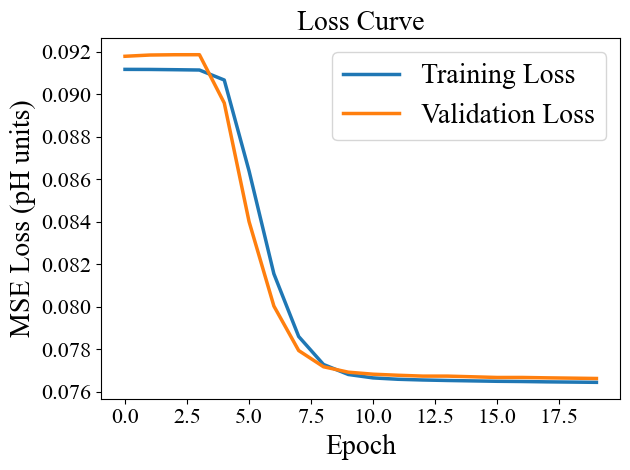

In [10]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from glob import glob
from matplotlib import pyplot as plt
from skimage import io
import os

def create_datasets_from_sample_ph(ph_path):
    '''
    :param ph_path: fold path containing standard pH sample images
    :return: an array with shape (62500*7, 4), including RGB values and corresponding pH label.
    '''
    ph_files = os.listdir(ph_path)
    datasets = np.zeros((62500*7, 4), dtype=np.float32)
    
    for i, ph in enumerate(ph_files):
        ph_v = float(ph.split('.')[0] + '.' + ph.split('.')[1])
        rgb = io.imread(os.path.join(ph_path, ph))
        rgb = rgb[400:650, 550:800]
        rgb = np.reshape(rgb, (-1, 3)) / 255
        ph_v = np.ones((rgb.shape[0], 1), dtype=np.float32) * ph_v
        data = np.concatenate((rgb, ph_v), axis=1)
        datasets[i*62500:(i+1)*62500] = data
    
    return datasets

def model_train_saving(datasets):
    '''
    Train a neural network model = model.pk00.keras
    '''
    def parse(x):
        return x[:3], x[-1]

    train_datasets, test_datasets = train_test_split(datasets, test_size=0.1, shuffle=True)
    train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets)
    train_datasets = train_datasets.map(parse).batch(batch_size=50).repeat()
    test_datasets = tf.data.Dataset.from_tensor_slices(test_datasets)
    test_datasets = test_datasets.map(parse).batch(batch_size=50).repeat()

    x_in = tf.keras.layers.Input(shape=(3,))
    x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x_in)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x_out = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(x_in, x_out)

   
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.MSE])

    model.fit(train_datasets, epochs=20, steps_per_epoch=7875,
              validation_data=test_datasets, validation_steps=875)

    model.save('model.pk00.keras')
    return model

if __name__ == '__main__':
    ph_path = r'C:/MODE1002/202312_21/pHCalib/'
    figures_path = r'C:/ProgramData/PreSens/VisiSensVS/Data/MODE1002/202401_24/'

    if os.path.exists('model.pk00.keras'):
        print('Found trained model, loading...')
        model = tf.keras.models.load_model('model.pk00.keras')
    else:
        print('Training new model...')
        datasets = create_datasets_from_sample_ph(ph_path)
        model = model_train_saving(datasets)
        print('Model trained and saved as model.pk00.keras')

    # Path to model
    model_directory = 'model.pk00.keras'

    # Load and summarize
    loaded_model = tf.keras.models.load_model(model_directory)
   

    # Begin predictions
    print('Starting predictions...')
    images = glob(figures_path + '*.png', recursive=True)
    for image_path in tqdm(images):
        image = io.imread(image_path)[150:900, 200:900]
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        t = cv.threshold(gray, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(t[1])
        image = image[y:y + h, x:x + w]
        image = np.flipud(image)
        image = image[50+70:-5, 20:-50]
        a1, b1, _ = image.shape
        image_ = np.float32(np.reshape(image, (-1, 3)) / 255)

        ph_p = model.predict(image_)
        ph_p = np.reshape(ph_p, (a1, b1))

        plt.ioff()
        fig = plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.imshow(image)
        plt.xlabel('Raw image')
        plt.xticks([]); plt.yticks([])
        plt.subplot(122)
        plt.imshow(ph_p, cmap='RdYlGn', vmin=5.4, vmax=7.6)
        plt.colorbar()
        plt.xlabel('pH_Predicted')
        plt.xticks([]); plt.yticks([])

        plt.savefig(os.path.abspath(image_path).split('.')[-2] + '_pre.svg')
        plt.close(fig)
        plt.imsave(os.path.abspath(image_path).split('.')[-2] + '_pre.tiff', ph_p)
        plt.show()
        break  # remove this line if you want predictions for all images
        print(image_path, 'save successful')

    # Plot training losses
    datasets = create_datasets_from_sample_ph(ph_path)

    def parse(x):
        return x[:3], x[-1]

    train_datasets, test_datasets = train_test_split(datasets, test_size=0.1, shuffle=True)
    train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets)
    train_datasets = train_datasets.map(parse).batch(batch_size=50).repeat()
    test_datasets = tf.data.Dataset.from_tensor_slices(test_datasets)
    test_datasets = test_datasets.map(parse).batch(batch_size=50).repeat()

   
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.MSE])

    history = model.fit(train_datasets, epochs=20, steps_per_epoch=7875,
                        validation_data=test_datasets, validation_steps=875)


plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5)

# Axis labels and title 
plt.xlabel('Epoch', fontname='Times New Roman', fontsize=20)
plt.ylabel('MSE Loss (pH units)', fontname='Times New Roman', fontsize=20)
plt.title('Loss Curve', fontname='Times New Roman', fontsize=20)
plt.yticks(fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=16, fontname='Times New Roman')

# Legend styling
plt.legend(prop={'family': 'Times New Roman', 'size': 20})
plt.tight_layout()
plt.show()



Training new model...
Starting predictions...


0it [00:00, ?it/s]


Epoch 1/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 2/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 3/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 4/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 5/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0881 - val_mean_squared_error: 0.0881
Epoch 6/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.0827 - val_mean_squared_error: 0.0827
Epoch 7/20
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0826 - mean_squared_error: 0.

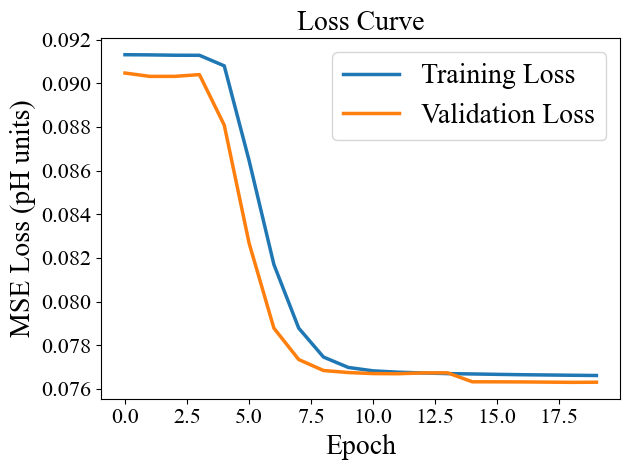

In [6]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from glob import glob
from matplotlib import pyplot as plt
from skimage import io
import os

def create_datasets_from_sample_ph(ph_path):
    '''
    :param ph_path: fold path containing standard pH sample images
    :return: an array with shape (62500*7, 4), including RGB values and corresponding pH label.
    '''
    ph_files = os.listdir(ph_path)
    datasets = np.zeros((62500*7, 4), dtype=np.float32)
    
    for i, ph in enumerate(ph_files):
        ph_v = float(ph.split('.')[0] + '.' + ph.split('.')[1])
        rgb = io.imread(os.path.join(ph_path, ph))
        rgb = rgb[400:650, 550:800]
        rgb = np.reshape(rgb, (-1, 3)) / 255
        ph_v = np.ones((rgb.shape[0], 1), dtype=np.float32) * ph_v
        data = np.concatenate((rgb, ph_v), axis=1)
        datasets[i*62500:(i+1)*62500] = data
    
    return datasets

def model_train_saving(datasets):
    '''
    Train a neural network model = model.pk00.keras
    '''
    def parse(x):
        return x[:3], x[-1]

    train_datasets, test_datasets = train_test_split(datasets, test_size=0.1, shuffle=True)
    train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets)
    train_datasets = train_datasets.map(parse).batch(batch_size=50).repeat()
    test_datasets = tf.data.Dataset.from_tensor_slices(test_datasets)
    test_datasets = test_datasets.map(parse).batch(batch_size=50).repeat()

    x_in = tf.keras.layers.Input(shape=(3,))
    x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x_in)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x_out = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(x_in, x_out)

   
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.MSE])

    model.fit(train_datasets, epochs=20, steps_per_epoch=7875,
              validation_data=test_datasets, validation_steps=875)

    model.save('model.pk00.keras')
    return model

if __name__ == '__main__':
    ph_path = r'C:/MODE1002/202312_21/pHCalib/'
    figures_path = r'C:/ProgramData/PreSens/VisiSensVS/Data/MODE1002/202401_24/'

    if os.path.exists('model.pk00.keras'):
        print('Found trained model, loading...')
        model = tf.keras.models.load_model('model.pk00.keras')
    else:
        print('Training new model...')
        datasets = create_datasets_from_sample_ph(ph_path)
        model = model_train_saving(datasets)
        print('Model trained and saved as model.pk00.keras')

    # Path to model
    model_directory = 'model.pk00.keras'

    # Load and summarize
    loaded_model = tf.keras.models.load_model(model_directory)
   

    # Begin predictions
    print('Starting predictions...')
    images = glob(figures_path + '*.png', recursive=True)
    for image_path in tqdm(images):
        image = io.imread(image_path)[150:900, 200:900]
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        t = cv.threshold(gray, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(t[1])
        image = image[y:y + h, x:x + w]
        image = np.flipud(image)
        image = image[50+70:-5, 20:-50]
        a1, b1, _ = image.shape
        image_ = np.float32(np.reshape(image, (-1, 3)) / 255)

        ph_p = model.predict(image_)
        ph_p = np.reshape(ph_p, (a1, b1))

        plt.ioff()
        fig = plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.imshow(image)
        plt.xlabel('Raw image')
        plt.xticks([]); plt.yticks([])
        plt.subplot(122)
        plt.imshow(ph_p, cmap='RdYlGn', vmin=5.4, vmax=7.6)
        plt.colorbar()
        plt.xlabel('pH_Predicted')
        plt.xticks([]); plt.yticks([])

        plt.savefig(os.path.abspath(image_path).split('.')[-2] + '_pre.svg')
        plt.close(fig)
        plt.imsave(os.path.abspath(image_path).split('.')[-2] + '_pre.tiff', ph_p)
        plt.show()
        break  # remove this line if you want predictions for all images
        print(image_path, 'save successful')

    # Plot training losses
    datasets = create_datasets_from_sample_ph(ph_path)

    def parse(x):
        return x[:3], x[-1]

    train_datasets, test_datasets = train_test_split(datasets, test_size=0.1, shuffle=True)
    train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets)
    train_datasets = train_datasets.map(parse).batch(batch_size=50).repeat()
    test_datasets = tf.data.Dataset.from_tensor_slices(test_datasets)
    test_datasets = test_datasets.map(parse).batch(batch_size=50).repeat()

   
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.MSE])

    history = model.fit(train_datasets, epochs=20, steps_per_epoch=7875,
                        validation_data=test_datasets, validation_steps=875)


plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5)

# Axis labels and title 
plt.xlabel('Epoch', fontname='Times New Roman', fontsize=20)
plt.ylabel('MSE Loss (pH units)', fontname='Times New Roman', fontsize=20)
plt.title('Loss Curve', fontname='Times New Roman', fontsize=20)
plt.yticks(fontsize=16, fontname='Times New Roman')
plt.xticks(fontsize=16, fontname='Times New Roman')

# Legend styling
plt.legend(prop={'family': 'Times New Roman', 'size': 20})
plt.tight_layout()
plt.show()

